# SOFIA/FORCAST Galactic Center Combine Fields Notebook

## Preliminary Steps - Select file to use from config.py and load in required packages

In [1]:
#import all required packages
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join, vstack, Table
from astropy.coordinates import SkyCoord, search_around_sky, Angle

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [2]:
#new functions needed for this notebook
from astropy.coordinates.matching import _get_cartesian_kdtree

from regions import read_ds9, write_ds9, CircleSkyRegion

In [3]:
#import configuration for selected file
#from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

from config import *

In [4]:
#change directory to where data is
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

In [5]:
def CombineFieldResults(CatName,wavelength): # #Name options- 'CombCat', 'SegCat', 'DaoCat'
    #pick a field to start with so we can get the table structure. 
    #The files for the field cannot be empty or an error message will display
    startfield=FieldA.name

    if os.path.exists(startfield+'_'+str(wavelength)+'um_'+CatName+'.fits'):
        cat=Table.read(startfield+'_'+str(wavelength)+'um_'+CatName+'.fits')

        #fix for issue with combining tables with objects as columns
        cat['RA(J2000)']=cat['sky_centroid'].ra
        cat['DEC(J2000)']=cat['sky_centroid'].dec
        cat.remove_column('sky_centroid')

    else:
        print('Error... Must pick another file to start with')
        
        
    #loop through all the saved photometry tables for individual fields and append them together
    for info in field._registry:
        filename=info.filename
        name=info.name

        #print('\nLoading in photometry data from field: ', name)

        if name is not startfield:

            if os.path.exists(name+'_'+str(wavelength)+'um_'+CatName+'.fits'):
                newtab1=Table.read(name+'_'+str(wavelength)+'um_'+CatName+'.fits')

                #fix for issue with combining tables with objects as columns
                newtab1['RA(J2000)']=newtab1['sky_centroid'].ra
                newtab1['DEC(J2000)']=newtab1['sky_centroid'].dec
                newtab1.remove_column('sky_centroid')

                #combine tables
                cat=vstack([cat,newtab1])

    #re-add "sky_centroid" column 
    cat['sky_centroid']=SkyCoord(cat['RA(J2000)'],cat['DEC(J2000)'],unit=u.deg)

    #print the table sizes to get source counts
    #print('Raw number of combinded sources: ', len(cat))
    
    #rename field based id to anothter name to avoid confusion
    cat.rename_column('id', 'old_id')

    #add new ids to the master catalog
    cat['id']=np.linspace(1,len(cat),len(cat),dtype=np.int64)

    #return combined catalog
    return cat
    

In [6]:
#source coords should be skycoord objects, sep should be an angular quantity e.g., 4*u.arcsec
def remove_duplicates(cat, sep):
	sourcecoords=cat['sky_centroid']

	#create KD Tree
	kdt=_get_cartesian_kdtree(sourcecoords)
    
	#search radius
	r = (2 * np.sin(Angle(sep) / 2.0)).value #search radius
    
	#initialize counter
	counter=0
    
	#create array to hold matches
	matchstore=np.zeros(len(cat),dtype=np.int)
    
	#loop through and find all matching sources within crossmatch radius
	for i, matches in enumerate(kdt.query_ball_tree(kdt,r)):
		if len(matches)>1:
			counter+=1
			
			for match in matches:
				if match!=matches[(match+1)%len(matches)]:
					matchstore[match]=matches[(match+1)%len(matches)]+1
				else:
					matchstore[match]=matches[(match+2)%len(matches)]+1

	#store possible crossmatches
	cat['selfXmatch']=matchstore
	print('number of likely duplicates: ', counter)
    
	#create keep and remove lists
	keep=[]
	remove=[]
    
	#loop through and mark sources to keep and remove based on which has the greater aperture photometry snr
	for row in cat:
		if row['selfXmatch']>0:
			#print(row['Master_id'])
			idx1 = row['id']
			idx2 = row['selfXmatch']
			
			row1=cat[cat['id']==idx1]
			row2=cat[cat['id']==idx2]
			
			snr1=row1['aper_snr_4pix'].data[0]
			snr2=row2['aper_snr_4pix'].data[0]
			           
			if snr1>snr2:
				keep.append(idx1)
				remove.append(idx2)
			else:
				keep.append(idx2)
				remove.append(idx1)

	#remove duplicates in lists
	keep=list(set(keep))
	remove=list(set(remove))
    
	#remove duplicates in table
	removeIdx=np.array(remove)-1 #fix zero/one initialization issue
	cat.remove_rows(removeIdx)
	
	return cat

In [7]:
def makeDS9file(savename, table, radius, color='green', labelon=False,label='ColumnName'):
    scs=table['sky_centroid']
    
    decimals = 1 # number of decimal places to display with labels
    
    #loop through and create region instances for each source
    regions=[]
    for i in range(0,len(scs)):
        region = CircleSkyRegion(scs[i], radius)
        regions.append(region)
            #write out region file
    write_ds9(regions, savename)
    
    hld=""
    with open(savename, 'r+') as f:
        lineno=0
        for line in f:
            if lineno<len(table):
                if labelon:
                    text=line.replace(r')', r') # color='+color+' text={'+str(np.round(table[label][lineno-2],decimals))+'}')
                else:
                    text=line.replace(r')', r') # color='+color)
                hld=hld+text
                lineno=lineno+1
        f.seek(0)
        f.write(hld)
        f.truncate()

In [ ]:
#find the 'not' indcies for sources in table
def findNOTindex(tab,index):
    allpos=np.linspace(0,len(tab)-1,len(tab),dtype=np.int64) 
    notindex=list(set(allpos)-set(index))
    return notindex

## Combine data files for each field at 25 um

In [8]:
#create initial master catalog at 25 um
mastercat25=CombineFieldResults('CombCat',25)

#print the master catalog
mastercat25

type,old_id,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,RA(J2000),DEC(J2000),sky_centroid,id
,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,deg,deg,"deg,deg",
bytes1,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,object,int64
C,1,186.13215812089783,44.83908685070949,"266.3254722621009,-29.07789334142956",4.251441381840274,0.08140057006109706,7.009887388867945,0.1414690116539936,9.333651826471463,0.24034146855993158,842.3889699154489,0.00015792294881538803,0.00037795126751484764,0.005781510100510126,363.0956726074219,326.0785093413304,4.243126847454111,75.65767425773959,52.64931061971556,6.984424127310321,124.05814677265663,161.23851377287892,9.258821016995999,160.89590869049604,473.84379557743995,FieldA,25,3.856358236558295,4.361264416619696,5.239291643470527,2.284067037427705,2.164161800551066,29.94547828716522,266.3254722621009,-29.07789334142956,"266.3254722621009,-29.07789334142956",1
C,2,91.13388232439642,221.0476097606492,"266.34865390850393,-29.040300695372114",1.3087028693588476,0.06457617602575318,2.1016104813737044,0.11298118086528029,2.570591187679788,0.19357004533413544,842.3889699154489,0.00011159306027058632,0.0005865174569878199,0.0052890662534054115,477.7574157714844,475.80978975703977,1.3028275716656568,19.176781006656906,52.64931061971556,2.083617382188308,29.63774817430125,161.23851377287892,2.5177135084410716,30.19705170464805,473.84379557743995,FieldA,25,4.303490864826108,4.548264914504913,5.073429306251551,2.282598650049977,2.0182597334875942,31.718048708673404,266.34865390850393,-29.040300695372114,"266.34865390850393,-29.040300695372114",2
C,3,214.3263472674334,138.54481158630034,"266.31859196098685,-29.057902466534006",4.517279878238537,0.06429089590388001,9.700689650183616,0.11249368591449324,18.396979270647673,0.1928197424831015,842.3889699154489,0.005476475752424609,0.007393471952174815,0.010939288794574635,477.7574157714844,476.6207881826312,4.228947205247794,70.1773179717275,52.64931061971556,8.817670839149462,150.50326768165246,161.23851377287892,15.80198521373098,271.30942864767303,473.84379557743995,FieldA,25,4.0223423402092715,4.259147699153211,5.6694189581002234,2.6003146112532844,2.1980109666265277,-56.042078181573224,266.31859196098685,-29.057902466534006,"266.31859196098685,-29.057902466534006",3
C,4,212.7142389276733,141.23325791893993,"266.31898545191007,-29.05732895919832",4.577030147285304,0.06426838656977268,10.718344604081759,0.11245133486776629,21.375549586640382,0.1926839507467687,842.3889699154489,0.006605751189177805,0.00894511909769135,0.011903154200365071,477.7574157714844,475.7045142320095,4.2292419010497255,69.01698575128042,52.64931061971556,9.653243099985302,164.90305656388173,161.23851377287892,18.245455370520183,315.52690022699494,473.84379557743995,FieldA,25,4.374031773347815,4.086774694774066,5.73071061687469,2.6742723959937145,2.1663725542983783,-55.15291558906831,266.31898545191007,-29.05732895919832,"266.31898545191007,-29.05732895919832",4
C,5,208.6319409033432,157.28357758668136,"266.31998201863314,-29.05390495647942",8.761508922127174,0.0642364378465394,22.78083532228061,0.11241803572221779,43.08542487402444,0.1926180723563314,842.3889699154489,0.00772719273513307,0.011328467887221014,0.01467723523285137,477.7574157714844,475.60596309923363,8.354677551596744,146.12537611822236,52.64931061971556,21.534914250031168,386.672452363

In [9]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat25.write('masterCatComb_FromFields_25um_NoCuts.fits',overwrite=True)

In [10]:
#write out save ds9 region files  - Optional for inspection
#set size of regions 
r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9file('mastercatComb_25um_labelID.reg', mastercat25, r, color='yellow', labelon=True, label="id")
makeDS9file('mastercatComb_25um_label4pixSNR.reg', mastercat25, r, color='cyan', labelon=True, label="aper_snr_4pix")

In [11]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included', len(mastercat25))
mastercat25=remove_duplicates(mastercat25, 3.0*u.arcsec)
print('Number of sources with duplicates removed', len(mastercat25))

Number of sources with duplicates included 1787
number of likely duplicates:  377


C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_18912/2402376784.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matchstore=np.zeros(len(cat),dtype=np.int)


Number of sources with duplicates removed 1589


In [12]:
#write 'master' catalogs to fits - optional for testing
#mastercat25.write('masterCat_FromFields_noDuplicates_25um.fits',overwrite=True)

In [13]:
#write out save ds9 region files - optional for testing
makeDS9file('mastercat_noDuplicates_25um_labelID.reg', mastercat25, r, color='magenta', labelon=True, label="id")

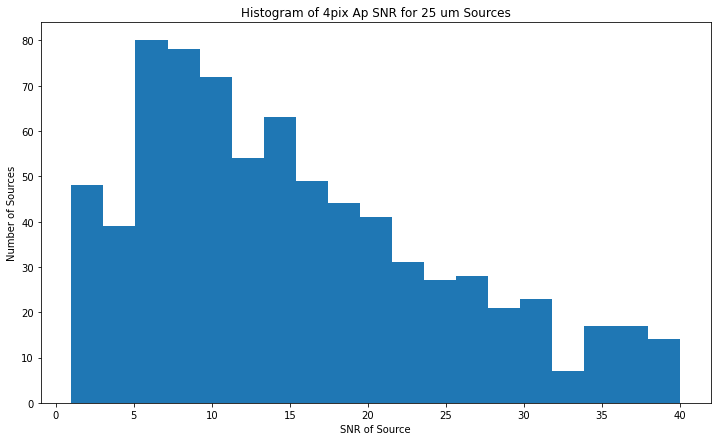

In [14]:
#now lets look at SNR distrobution
binlist=np.linspace(1,40,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of 4pix Ap SNR for 25 um Sources')
plt.hist(mastercat25['aper_snr_4pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [15]:
#lets examine SNR cuts...
snrcut4pix=mastercat25['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
mcat25snrcut=mastercat25[snrcut4pix] #apply snr cut

print("Number of Catalog Sources after SNR cut: ", len(mcat25snrcut))

Number of Catalog Sources after SNR cut:  973


In [16]:
#other cuts to consider????

In [17]:
makeDS9file('mastercatComb_4pixSNRselect_25m_NoLabel.reg', mcat25snrcut, r, color='green')

In [ ]:
#Optional - write 'master' catalogs to fits prior to quality cuts
mcat25snrcut.write('masterCat_25um_Step3.fits',overwrite=True)

## Repeat process for 37 um data

In [18]:
#create initial master catalog at 37 um
mastercat37=CombineFieldResults('CombCat',37)

#print the master catalog
mastercat37

type,old_id,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,RA(J2000),DEC(J2000),sky_centroid,id
,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,deg,deg,"deg,deg",
bytes1,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,object,int64
C,1,142.4222167812415,244.69398363028392,"266.33571101881336,-29.03729396282822",16.823313759787407,0.13052538734462685,38.275534963104235,0.2283676991062819,68.07677396548733,0.39151472058742304,842.3887129996068,0.016057226720894983,0.019351436261361116,0.020377260213605218,400.12127685546875,398.9379262555463,15.977912100302554,271.5398303385732,52.64929456247541,35.686492380931874,612.0870483772352,161.238464597581,60.46815903012367,1036.7759983151554,473.8436510622788,FieldA,37,4.070412929544192,3.9802422511197113,5.779556083285771,2.5329860953472934,2.373112703084954,20.07691949172173,266.33571101881336,-29.03729396282822,"266.33571101881336,-29.03729396282822",1
C,2,143.5452530013948,244.50410045870763,"266.33543699669957,-29.037334485899724",16.76676079088167,0.13054563467289776,37.57966399928746,0.22840555953571776,67.17481107905367,0.391592620955339,842.3887129996068,0.016504211012411327,0.020389312693609014,0.021973153005091846,400.12127685546875,399.39843961883486,15.897825723767975,269.07228308078123,52.64929456247541,34.91855035625177,597.0277710914795,161.238464597581,59.35439547503041,1014.5156440506069,473.8436510622788,FieldA,37,3.9218353512269655,3.986797467245211,5.758378688553219,2.5114391636468456,2.3774413842493956,2.6297466961680778,266.33543699669957,-29.037334485899724,"266.33543699669957,-29.037334485899724",2
C,3,185.8843184824861,53.32524497654224,"266.325104824915,-29.07811945352745",3.2922456491385277,0.1288646792540781,5.946337621550762,0.22777968022304018,9.70170351559762,0.4130127488866621,842.3887129996068,0.0012552982252203642,0.0022844224406179886,0.009843589123761744,400.12127685546875,398.4387799392621,3.226155083115148,49.575878874489725,52.64929456247541,5.743935263104162,88.59866122176086,161.238464597581,9.106888421387204,137.98415905490256,473.8436510622788,FieldA,37,4.1585647558307075,4.184071346916277,5.341338874912004,2.343391052754806,2.190549026587604,-5.856931798641261,266.325104824915,-29.07811945352745,"266.325104824915,-29.07811945352745",3
C,4,213.49728794963903,148.54816508325013,"266.31836645961846,-29.057804902179896",6.494607739758986,0.13310729707661068,14.312205185063284,0.23286900430662769,25.933423437623027,0.3990069575609686,842.3887129996068,0.004691032885682408,0.007080396648139035,0.015030417264407871,400.12127685546875,399.3883021741741,6.2476281675584335,100.29052696171526,52.64929456247541,13.555830245199093,223.54164787238813,161.238464597581,23.710607287818057,391.79407109255396,473.8436510622788,FieldA,37,4.14391381367146,4.22329857289421,5.694095220221748,2.629873388595846,2.185815736731943,-58.82213122682895,266.31836645961846,-29.057804902179896,"266.31836645961846,-29.057804902179896",4
C,5,212.18811637382836,150.4513954114122,"266.3186860037761,-29.05739890297304",6.54538637221277,0.13306405204379268,14.877321306298306,0.232778276627887,28.09258049300846,0.39882551009772577,842.3887129996068,0.005485694207867119,0.00901293769265498,0.01733913996203883,400.12127685546875,398.3890928989456,6.256568441983109,98.05896050842077,52.64929456247541,13.992816394969969,227.84673284334434,161.2384645975

In [19]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat37.write('masterCatComb_FromFields_37um_NoCuts.fits',overwrite=True)

In [20]:
#write out save ds9 region files  - Optional for inspection
#set size of regions 
r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9file('mastercatComb_37um_labelID.reg', mastercat37, r, color='yellow', labelon=True, label="id")
makeDS9file('mastercatComb_37um_label4pixSNR.reg', mastercat37, r, color='cyan', labelon=True, label="aper_snr_4pix")

In [21]:
#Now lets look at possible duplications that may exist because of overlapping data coverage

print('Number of sources with duplicates included', len(mastercat37))

mastercat37=remove_duplicates(mastercat37, 3.0*u.arcsec)

print('Number of sources with duplicates removed', len(mastercat37))

Number of sources with duplicates included 1701
number of likely duplicates:  367


C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_18912/2402376784.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matchstore=np.zeros(len(cat),dtype=np.int)


Number of sources with duplicates removed 1508


In [22]:
#write 'master' catalogs to fits - optional for testing
#mastercat37.write('masterCat_FromFields_noDuplicates_37um.fits',overwrite=True)

In [23]:
#write out save ds9 region files - optional for testing
makeDS9file('mastercat_noDuplicates_37um_labelID.reg', mastercat37, r, color='magenta', labelon=True, label="id")

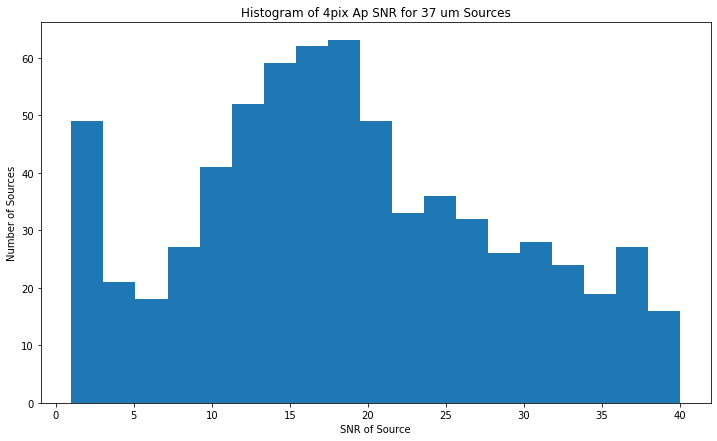

In [24]:
#now lets look at SNR distrobution
binlist=np.linspace(1,40,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of 4pix Ap SNR for 37 um Sources')
plt.hist(mastercat37['aper_snr_4pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [25]:
#lets examine SNR cuts...
snrcut4pix=mastercat37['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
mcat37snrcut=mastercat37[snrcut4pix] #apply snr cut

print("Number of Catalog Sources after SNR cut: ", len(mcat37snrcut))

Number of Catalog Sources after SNR cut:  1029


In [26]:
#more cuts to consider?

In [27]:
makeDS9file('mastercatComb_4pixSNRselect_37m_NoLabel.reg', mcat37snrcut, r, color='green')

In [ ]:
#Optional - write 'master' catalogs to fits prior to quality cuts
mcat37snrcut.write('masterCat_37um_Step3.fits',overwrite=True)

## Crossmatch the 25 and 37 um catalogs

In [28]:
#get source coordinates from both tables
sources25=mcat25snrcut['sky_centroid']
sources37=mcat37snrcut['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = sources25.search_around_sky(sources37, 3*u.arcsec) #use larger search radius?
print('Number of crossmatched 25/37 sources found: ', len(idx))

Number of crossmatched 25/37 sources found:  604


In [29]:
matched25=mcat25snrcut[rdx]
matched37=mcat37snrcut[idx]

In [31]:
notrdx=findNOTindex(mcat25snrcut,rdx)
only25=mcat25snrcut[notrdx]

notidx=findNOTindex(mcat37snrcut,idx)
only37=mcat37snrcut[notidx]

In [34]:
t1=Table()
t1['RA(J2000)']=matched25['RA(J2000)']
t1['DEC(J2000)']=matched25['DEC(J2000)']
t1['25um Flux (Jy)']=matched25['aper_sum_bkgsub_4pix']
t1['fwhm25']=matched25['fwhm']
t1['25um SNR']=matched25['aper_snr_4pix']
t1['37um Flux (Jy)']=matched37['aper_sum_bkgsub_4pix']
t1['37um SNR']=matched37['aper_snr_4pix']
t1['fwhm37']=matched37['fwhm']


t2=Table()
t2['RA(J2000)']=only25['RA(J2000)']
t2['DEC(J2000)']=only25['DEC(J2000)']
t2['25um Flux (Jy)']=only25['aper_sum_bkgsub_4pix']
t2['25um SNR']=only25['aper_snr_4pix']
t2['fwhm25']=only25['fwhm']
t2['37um Flux (Jy)']=-1
t2['37um SNR']=-1
t2['fwhm37']=-1


t3=Table()
t3['RA(J2000)']=only37['RA(J2000)']
t3['DEC(J2000)']=only37['DEC(J2000)']
t3['25um Flux (Jy)']=-1
t3['25um SNR']=-1
t3['fwhm25']=-1
t3['37um Flux (Jy)']=only37['aper_sum_bkgsub_4pix']
t3['37um SNR']=only37['aper_snr_4pix']
t3['fwhm37']=only37['fwhm']

In [35]:
mastercat=vstack((t1,t2,t3))

In [36]:
#change format of columns to save fewer decimal places
for col in mastercat.colnames:
    if col!='RA(J2000)' and col!='DEC(J2000)' and col!='type': #skip columns that aren't relevant
        mastercat[col].info.format = '%.4G'

#display catalog
mastercat

RA(J2000),DEC(J2000),25um Flux (Jy),fwhm25,25um SNR,37um Flux (Jy),37um SNR,fwhm37
deg,deg,,pix,,,,pix
float64,float64,float64,float64,float64,float64,float64,float64
266.33591716284303,-29.037906320021353,19.06,5.873,348.9,15.98,271.5,5.78
266.3254722621009,-29.07789334142956,4.243,5.239,75.66,3.226,49.58,5.341
266.31859196098685,-29.057902466534006,4.229,5.669,70.18,6.248,100.3,5.694
266.31998201863314,-29.05390495647942,8.355,5.906,146.1,8.052,130.6,5.834
266.3362279098425,-29.038785430975665,12.45,5.751,226.6,11.1,184.4,5.717
266.33448072434913,-29.038787791948685,8.867,5.598,160,10.02,164.6,5.859
266.35377268616793,-29.055963810072285,1.6,5.758,19.96,1.126,9.995,5.751
266.3549333829732,-29.054051210496706,1.783,5.522,24.06,0.9815,6.991,5.635


In [37]:
#write out final catalog
mastercat.write('masterCat_step3_final.fits',overwrite=True)

## Optional - Create combined Segment Map Catalogs (mainly for testing purposes)

In [39]:
#create combined field segment map source catalog at 25 um
Segcat25=CombineFieldResults('segCat',25)

#Remove duplications from overlapping fields
SegCat25=remove_duplicates(Segcat25, 3.0*u.arcsec)

#lets examine SNR cuts...
snrcut4pix=SegCat25['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
Segcat25snr=SegCat25[snrcut4pix] #apply snr cut
print("Number of 25 um Seg Catalog Sources after SNR cut: ", len(Segcat25snr))

#write ds9 file
makeDS9file('Segcat_4pixSNRselect_25m_NoLabel.reg', Segcat25snr, r, color='green')

#write fits file
Segcat25snr.write('SegCat_CombinedFields_snrcut.fits',overwrite=True)

C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_25392/2402376784.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matchstore=np.zeros(len(cat),dtype=np.int)


number of likely duplicates:  294
Number of 25 um Seg Catalog Sources after SNR cut:  858


In [40]:
Segcat25snr

old_id,xcentroid,ycentroid,background_centroid,background_mean,background_sum,area,semimajor_sigma_seg,semiminor_sigma_seg,orientation_seg,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm_seg,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,RA(J2000),DEC(J2000),sky_centroid,id,selfXmatch
,,,,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,deg,deg,"deg,deg",,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,object,int64,int32
1,185.74025305952063,45.29468593234474,-0.0010024959751888693,-0.0004956385032757274,-0.05005948883084846,101.0,2.6243450015424092,2.1592520002946807,6.6485615155907,0.14612593264096238,-0.01593585441761772,0.21355446379362664,0.5683636138426366,0.1772225073206377,1.2153954245193501,5.658813338648118,9.452813107528392,0.26268936835739903,2.275454410029209,5.635387378601118,0.10810196399688721,-0.0004975240031514727,-0.0005376331807221336,0.00013432667608972187,16.156001325545247,185.7402530596197,45.2946859322694,"266.3255679286236,-29.0777961489855",4.223261726128053,0.07965694794375933,6.990669465142625,0.13954518125803658,9.274056937915002,0.238326336657559,842.3889672608536,0.00015622811410386216,0.00040810074823285295,0.005793276622484106,419.3362724757975,336.2819897809317,4.215036423646986,75.11780662752693,52.64931045380335,6.96547947629436,123.6823749899232,161.2385132647728,9.200029215585404,159.73011029162714,473.84379408423024,FieldA,25,4.378306921607122,3.8199525587441663,5.1955358339515545,2.2621740636932857,2.149057712389039,11.862892326351194,266.3255679286236,-29.0777961489855,"266.3255679286236,-29.0777961489855",1,0
2,99.33997412427225,135.7560428642921,0.000645686407520613,0.01972296132447175,3.431795270458084,174.0,3.8835755737063407,3.2426723319262165,-1.7704318600475983,0.06633099263366786,0.0017786637010446392,0.09507543463733634,0.5502942012990037,0.1650291669664793,1.1976466248131257,8.42438032703874,--,--,nan,5.714359056859989,0.11486293375492096,0.019715966455985303,0.01957748140953601,0.0043672587653352255,6.10972394850931,99.33997412423895,135.75604286425096,"266.3466547631106,-29.058496515013818",2.2444751769657416,0.06317449923777498,5.263501701641234,0.11057385187481032,8.179289331002943,0.18959596849336177,842.3889672608536,-0.0022032085635257017,-0.0024315801082415126,0.006543116118794441,477.7574157714844,476.9713757719391,2.3604725886212847,38.64366558564773,52.64931045380335,5.618743774836334,96.69975751476773,161.2385132647728,9.223266035902828,157.8522858399414,473.84379408423024,FieldA,25,3.832897264201368,4.41238741642627,5.783185493264922,2.4629032764829675,2.44886216866295,-45.987069195414584,266.3466547631106,-29.058496515013818,"266.3466547631106,-29.058496515013818",2,0
3,83.94487721758777,159.5619761735801,0.0009578778421280461,0.03018293132272653,2.8371955443362937,94.0,2.9415442293194145,2.491499368532639,85.1490718882491,0.16076812412716185,-0.007671521450482014,0.11589662823547614,0.5315867109270886,0.15299612234316196,1.1806321392133556,6.418829011

In [41]:
#create combined field segment map source catalog at 37 um
Segcat37=CombineFieldResults('segCat',37)

#Remove duplications from overlapping fields
SegCat37=remove_duplicates(Segcat37, 3.0*u.arcsec)

#lets examine SNR cuts...
snrcut4pix=SegCat37['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
Segcat37snr=SegCat37[snrcut4pix] #apply snr cut
print("Number of 37 um Seg Catalog Sources after SNR cut: ", len(Segcat37snr))

#write ds9 file
makeDS9file('Segcat_4pixSNRselect_37m_NoLabel.reg', Segcat37snr, r, color='green')

#write fits file
Segcat37snr.write('SegCat_CombinedFields_snrcut.fits',overwrite=True)

C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_25392/2402376784.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matchstore=np.zeros(len(cat),dtype=np.int)


number of likely duplicates:  282
Number of 37 um Seg Catalog Sources after SNR cut:  920


In [42]:
Segcat37snr

old_id,xcentroid,ycentroid,background_centroid,background_mean,background_sum,area,semimajor_sigma_seg,semiminor_sigma_seg,orientation_seg,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm_seg,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,RA(J2000),DEC(J2000),sky_centroid,id,selfXmatch
,,,,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,deg,deg,"deg,deg",,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,object,int64,int32
1,165.88124869656778,135.1457600413451,0.105157953693618,0.08381862214796677,0.6705489771837342,8.0,0.8769722412230371,0.6688080918264174,43.894949188395,1.7498989131658533,-0.9346646218817445,1.7859701379371873,0.6468312744319636,0.2373668624976215,1.3112464576021408,1.836446066762363,3.0502143518220093,0.218849915392413,3.5576433313609304,0.3180231434827696,0.05132055655121803,0.08380100852482836,0.08372312982837603,0.0017530802984467436,1.2440902422001605,165.88124869667803,135.14576004139107,"266.32998730132323,-29.06066444114748",1.4361474202736453,0.13156885091446782,3.4240688268525985,0.2301722297471936,6.334599409822843,0.39444305527428686,842.3886494273573,-0.0004895834732235229,-0.0014007875371557087,0.015934638470782567,400.12127685546875,399.28152922907714,1.461923642823065,11.841245627924435,52.649290589209805,3.503008508410197,35.623862346703916,161.23845242945507,6.566585412767622,70.69985509181079,473.8436153028882,FieldA,37,4.6615991348491255,4.509769738878789,5.350586354743857,2.3200332857300094,2.223306826488856,47.27429070714086,266.32998730132323,-29.06066444114748,"266.32998730132323,-29.06066444114748",1,0
2,167.721005456061,139.46752245357496,0.10689638267581611,0.09481086211696702,0.6636760348187691,7.0,1.2340198435091818,0.5847190899471192,-21.821246697740367,0.970077048804135,1.5653987412335955,2.61146835817579,0.8806148239969739,0.5261671900798988,2.1104490424979696,2.273774403851281,3.4409512080472973,0.24859120479955898,3.6420654056456057,0.2440112566841834,0.04795633628964424,0.09331031030341473,0.09330699734645656,0.002666071464332059,0.9453907304634207,167.72100545600614,139.46752245360557,"266.3295382816666,-29.05974246988601",1.5821418218562586,0.13160807260993931,3.6855860075505813,0.23030600062649667,5.754407922891304,0.39480453920049835,842.3886494273573,-0.0003286288233462775,-0.0012227842082075061,0.01675698505552631,400.12127685546875,399.59329539155095,1.599443896272607,13.359639770918713,52.649290589209805,3.738573610450648,38.38912912650552,161.23845242945507,5.910126592638439,57.47936235547718,473.8436153028882,FieldA,37,4.172936348945814,3.6415464483904443,5.739674384677733,2.550069670800815,2.3192954259942944,58.439418286752016,266.3295382816666,-29.05974246988601,"266.3295382816666,-29.05974246988601",2,0
3,67.73793200190819,155.70307950024414,-0.004177105834915287,0.05753259209647462,0.2876629604823731,5.0,1.1947068696746086,0.28650901315579624,-34.92444736022005,4.463697121268363,10.778709370165084,8.41904981103734,0.9708185263629986,0.760184677573813

## testing...

In [66]:
np.max(Segcat25['fwhm'])

6.0680694089549565

In [67]:
np.min(Segcat25['fwhm'])

3.0486507818268596

In [68]:
np.mean(Segcat25['fwhm'])

5.457743928773992

In [69]:
np.std(Segcat25['fwhm'])

0.42717443772804187

In [70]:
np.mean(Segcat25['fwhm_seg'])

4.871949935807235

In [71]:
np.std(Segcat25['fwhm_seg'])

2.880269379660212

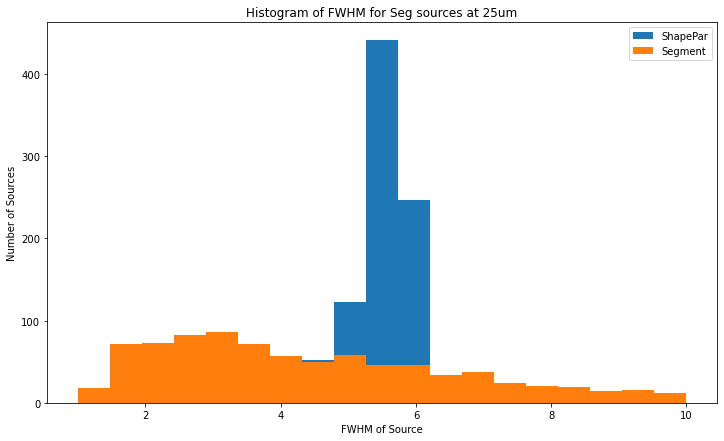

In [45]:
#now lets look at SNR distrobution
binlist=np.linspace(1,10,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of FWHM for Seg sources at 25um')
plt.hist(Segcat25['fwhm'],bins=binlist,label='ShapePar')
plt.hist(Segcat25['fwhm_seg'],bins=binlist,label='Segment')
plt.legend()
plt.xlabel('FWHM of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()

In [46]:
xmatch=mcat25snrcut['type']=='C'
segonly=mcat25snrcut['type']=='S'
daoonly=mcat25snrcut['type']=='D'

In [47]:
xmatch25=mcat25snrcut[xmatch]
seg25=mcat25snrcut[segonly]
dao25=mcat25snrcut[daoonly]

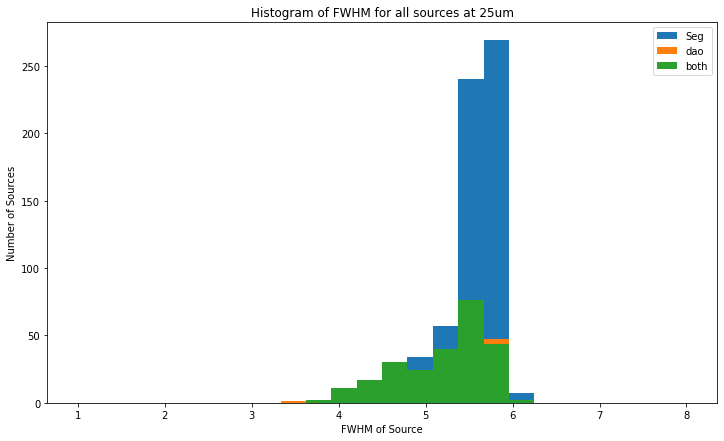

In [48]:
#now lets look at SNR distrobution
binlist=np.linspace(1,8,25)

plt.figure(figsize=(12,7))
plt.title('Histogram of FWHM for all sources at 25um')
plt.hist(seg25['fwhm'],bins=binlist,label='Seg')
plt.hist(dao25['fwhm'],bins=binlist,label='dao')
plt.hist(xmatch25['fwhm'],bins=binlist,label='both')
plt.legend()
plt.xlabel('FWHM of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()